In [1]:
from collections import defaultdict
from lxml import etree
from discoursegraphs import t
from discoursegraphs.readwrite.rst.rs3 import extract_relationtypes

In [2]:
RS3_EXAMPLE_FILE = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-1818.rs3'

In [3]:
def get_rs3_data(rs3_file):
    rs3_etree = etree.parse(rs3_file)
    reltypes = extract_relationtypes(rs3_etree)
    elements = defaultdict(lambda : defaultdict(str))
    children = defaultdict(list)

    for elem in rs3_etree.iter('segment', 'group'):
        elem_id = elem.attrib['id']
        parent_id = elem.attrib.get('parent')
        elements[elem_id]['parent'] = parent_id
        children[parent_id].append(elem_id)
        
        relname = elem.attrib.get('relname')
        elements[elem_id]['relname'] = relname
        if relname == None:
            # nodes without a parent have no relname attribute
            elements[elem_id]['nuclearity'] = 'root'
        else:
            reltype = reltypes.get(relname, 'span')
            elements[elem_id]['reltype'] = reltype
            if reltype == 'rst':
                # this elem is the S of an N-S relation, its parent is the N
                elements[elem_id]['nuclearity'] = 'satellite'
            elif reltype == 'multinuc':
                # this elem is one of several Ns of a multinuc relation.
                # its parent is the multinuc relation node.
                elements[elem_id]['nuclearity'] = 'nucleus'
            elif reltype == 'span':
                # this elem is the N of an N-S relation, its parent is a span
                elements[elem_id]['nuclearity'] = 'nucleus'
            else:
                raise NotImplementedError("Unknown reltype: {}".format(reltypes[relname]))
        
        elem_type = elem.tag
        elements[elem_id]['element_type'] = elem_type
        
        if elem_type == 'segment':
            elements[elem_id]['text'] = elem.text
        else:  # elem_type == 'group':
            elements[elem_id]['group_type'] = elem.attrib.get('type')
    return children, elements

In [4]:
cdict, edict = get_rs3_data(RS3_EXAMPLE_FILE)

In [5]:
print edict['5']
print
print edict['4']

defaultdict(<type 'str'>, {'nuclearity': 'nucleus', 'parent': '12', 'element_type': 'segment', 'text': ' haben sie den Ernst der Lage erkannt .', 'reltype': 'span', 'relname': 'span'})

defaultdict(<type 'str'>, {'nuclearity': 'satellite', 'parent': '5', 'element_type': 'segment', 'text': '  Auch wenn die Basis murrt ,', 'reltype': 'rst', 'relname': 'concession'})


In [93]:
def dt(child_dict, elem_dict, start_node=None):
    elem_id = start_node
    if elem_id not in elem_dict:
        return []
    
    elem = elem_dict[elem_id]
    elem_type = elem['element_type']
    
    if elem_type == 'segment':
        if elem['nuclearity'] == 'root':
            return t('N ({})'.format(elem_id), elem['text'])
        
        if elem['reltype'] == 'rst':
            # this elem is the S in an N-S relation
            assert elem_id not in child_dict
            return t('S ({})'.format(elem_id), elem['text'])

        elif elem['reltype'] == 'multinuc':
            # this elem is one of several Ns in a multinuc relation
            assert elem_id not in child_dict
            return t('N ({})'.format(elem_id), elem['text'])
            
        else:  # elem['reltype'] == 'span'
            # this elem is the N in an N-S relation
            assert len(child_dict[elem_id]) == 1
            satellite_id = child_dict[elem_id][0]
            satellite_elem = elem_dict[satellite_id]
            sat_subtree = dt(child_dict, elem_dict, start_node=satellite_id)
            relname = satellite_elem['relname']
            return t(relname, [
                ('N ({})'.format(elem_id), elem['text']),
                sat_subtree
            ])

    else:  # elem_type == 'group':
        if elem['reltype'] == 'rst':
            # this elem is the S in an N-S relation
            assert len(child_dict[elem_id]) == 1
            child_id = child_dict[elem_id][0]
            subtree = dt(child_dict, elem_dict, start_node=child_id)
            return t('S ({})'.format(elem_id), subtree)

        elif elem['reltype'] == 'multinuc':
            # this elem is one of several Ns in a multinuc relation
            assert len(child_dict[elem_id]) == 1
            child_id = child_dict[elem_id][0]
            subtree = dt(child_dict, elem_dict, start_node=child_id)
            return t('n ({})'.format(elem_id), subtree)

        else: # elem_type == 'group' and elem['reltype'] == 'span'
            raise NotImplementedError

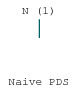

In [94]:
dt(cdict, edict, start_node='1') # OK

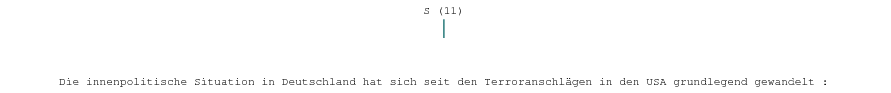

In [95]:
dt(cdict, edict, start_node='11') # OK

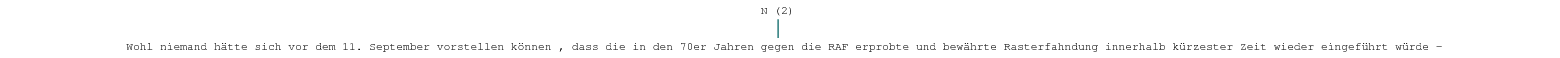

In [96]:
dt(cdict, edict, start_node='2') # OK

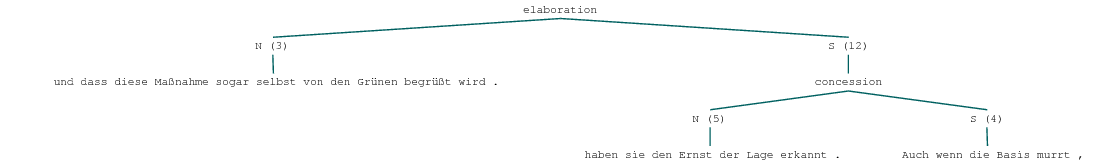

In [97]:
dt(cdict, edict, start_node='3') # OK, but wrong subtree order

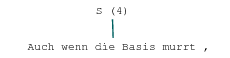

In [98]:
dt(cdict, edict, start_node='4') # OK

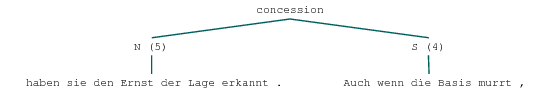

In [99]:
dt(cdict, edict, start_node='5') # OK, but wrong subtree order

In [100]:
dt(cdict, edict, start_node='6') # FAIL

NotImplementedError: 

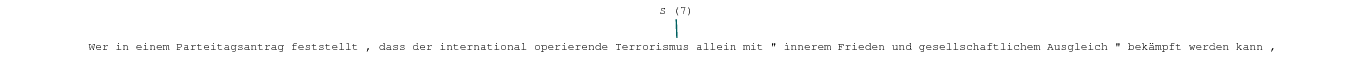

In [101]:
dt(cdict, edict, start_node='7') # OK

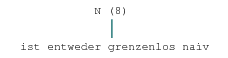

In [102]:
dt(cdict, edict, start_node='8') # OK

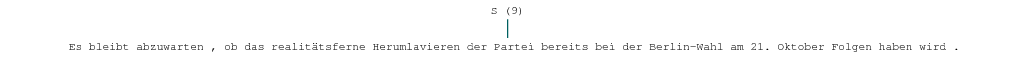

In [103]:
dt(cdict, edict, start_node='9') # OK

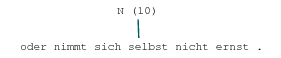

In [104]:
dt(cdict, edict, start_node='10') # OK

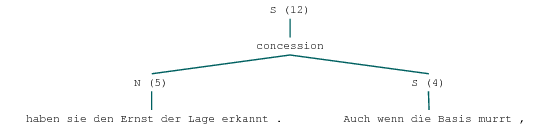

In [105]:
dt(cdict, edict, start_node='12') # OK, but wrong subtree order

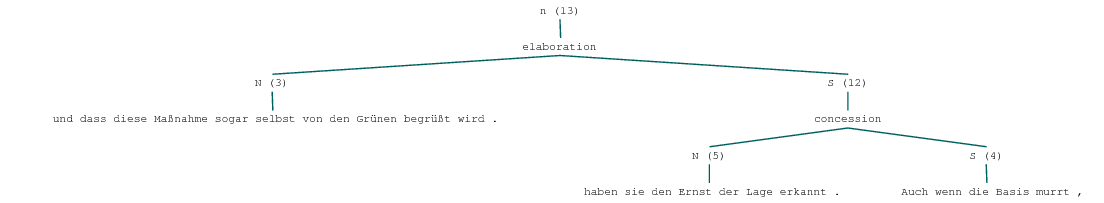

In [106]:
dt(cdict, edict, start_node='13') # OK, but wrong subtree order

In [107]:
dt(cdict, edict, start_node='14') # not implemented

NotImplementedError: 

In [108]:
dt(cdict, edict, start_node='15') # not implemented

NotImplementedError: 

In [109]:
dt(cdict, edict, start_node='16') # not implemented

NotImplementedError: 

In [110]:
dt(cdict, edict, start_node='17') # FAIL

NotImplementedError: 

In [111]:
dt(cdict, edict, start_node='18') # not implemented

NotImplementedError: 

In [112]:
dt(cdict, edict, start_node='19') # not implemented

NotImplementedError: 

In [113]:
dt(cdict, edict, start_node='20') # not implemented

NotImplementedError: 